In [78]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import itertools
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from stemming.porter2 import stem

from sklearn.dummy import DummyClassifier
from scikitplot import classifier_factory
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, learning_curve, ShuffleSplit

In [2]:
path = 'smsspamcollection/SMSSpamCollection'
messages = pandas.read_csv(path, sep='\t',
                           names=["label", "message"])
print(messages)
print(messages.groupby('label').describe())

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
5     spam  FreeMsg Hey there darling it's been 3 week's n...
6      ham  Even my brother is not like to speak with me. ...
7      ham  As per your request 'Melle Melle (Oru Minnamin...
8     spam  WINNER!! As a valued network customer you have...
9     spam  Had your mobile 11 months or more? U R entitle...
10     ham  I'm gonna be home soon and i don't want to tal...
11    spam  SIX chances to win CASH! From 100 to 20,000 po...
12    spam  URGENT! You have won a 1 week FREE membership ...
13     ham  I've been searching for the right words to tha...
14     ham                I HAVE A DATE ON SUNDAY WITH WILL!!
15    sp

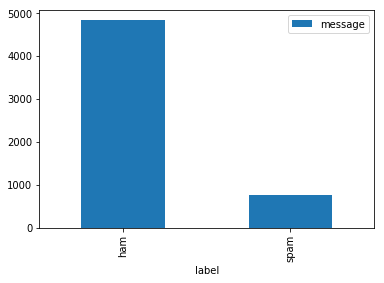

In [6]:
plt.figure()
messages.groupby(['label']).count().plot(kind='bar')
plt.show()
# выборка не сбалансированная, спама в 6 раз меньше, чем не спама.
# Если классификатор будет приписывать всем новым наблюдениям класс ham, том меры оценки работы классификатора все равно будут хорошими
# Если считать, что Positive - неспам, то recall = 1, precision = 4825/(4825+747)=0.866 - неплохие показатели. 
# (это всё если мы не будем решать проблему с выборкой и оставим как есть)
# Тем не менее, для задачи нахождения спама, это никак не годится. На почту обычного пользователя приходит значительно меньше спама, чем 
# релевантных писем, но нам нужно уметь хорошо классифицировать Negative, то есть спам.

In [3]:
#task 1
ham = messages.loc[messages['label'] == 'ham'][:747]
spam = messages.loc[messages['label'] == 'spam']
new_data = ham.append(spam).sample(frac=1).reset_index(drop=True)
print(new_data.head())
# срезала неспам, чтобы было поровну со спамом, сделала общий датасет и перемешала строки.

  label                                            message
0  spam  CDs 4u: Congratulations ur awarded £500 of CD ...
1   ham                   Ok i am on the way to home hi hi
2  spam  Hey Boys. Want hot XXX pics sent direct 2 ur p...
3   ham    Alright omw, gotta change my order to a half8th
4   ham  Ask g or iouri, I've told the story like ten t...


In [4]:
def tokenize(text):
    return word_tokenize(text)
#.lower() не нужен, потому что в CountVectorizer он есть и по дефолту True

In [5]:
def tokenize_no_punct(text):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(text)
# Note that if you use this option, 
# you lose natural language features special to word_tokenize like splitting apart contractions. - это минус метода

In [80]:
bow = CountVectorizer(tokenizer=tokenize)
bowed_messages = bow.fit_transform(new_data['message'])
msg_train, msg_test, label_train, label_test = train_test_split(bowed_messages, new_data['label'], test_size=0.2)

naive_model = MultinomialNB()
naive_model.fit(msg_train, label_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [81]:
label_pred1 = naive_model.predict(msg_test)
print(classification_report(label_test, label_pred1))

             precision    recall  f1-score   support

        ham       0.96      0.99      0.98       153
       spam       0.99      0.96      0.98       146

avg / total       0.98      0.98      0.98       299



In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

['ham' 'spam']
Confusion matrix, without normalization
[[147   4]
 [  8 140]]
Normalized confusion matrix
[[ 0.97350993  0.02649007]
 [ 0.05405405  0.94594595]]


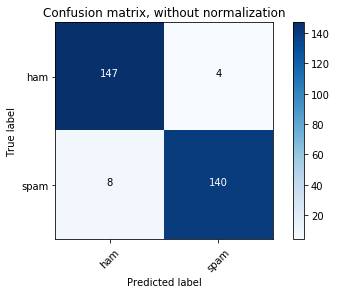

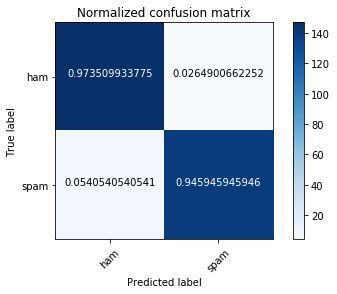

In [66]:
print(naive_model.classes_)
cnf_matrix = confusion_matrix(label_test, label_pred1)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=naive_model.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=naive_model.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [69]:
print(label_test.shape)

(299,)


In [ ]:
# Здесь был использован CountVectorizer с токенизатором, который считает пунктуацию отдельными токенами.
# TP, FN довольно немного, но, к сожалению, большинство ошибок - неправильное отнесение спама к неспаму (8).

In [7]:
bow2 = CountVectorizer(tokenizer=tokenize_no_punct)
bowed_messages2 = bow2.fit_transform(new_data['message'])
msg_train2, msg_test2, label_train2, label_test2 = train_test_split(bowed_messages2, new_data['label'], test_size=0.2)

naive_model2 = MultinomialNB()
naive_model2.fit(msg_train2, label_train2)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [8]:
label_pred2 = naive_model2.predict(msg_test2)
print(classification_report(label_test2, label_pred2))

             precision    recall  f1-score   support

        ham       0.95      0.98      0.96       142
       spam       0.98      0.95      0.96       157

avg / total       0.96      0.96      0.96       299



Confusion matrix, without normalization
[[139   3]
 [  8 149]]
Normalized confusion matrix
[[ 0.97887324  0.02112676]
 [ 0.05095541  0.94904459]]


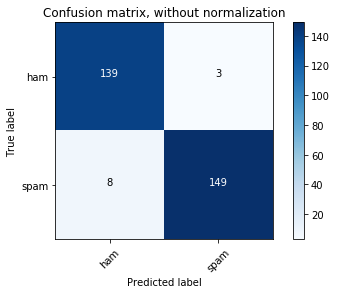

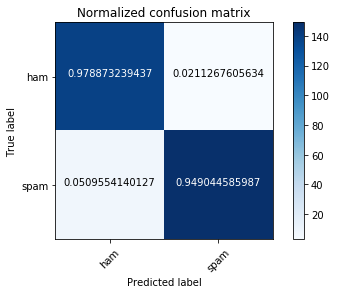

In [9]:
cnf_matrix2 = confusion_matrix(label_test2, label_pred2)
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=naive_model2.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=naive_model2.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# Здесь был использован CountVectorizer с токенизатором, который не считает пунктуацию отдельными токенами.
# TP, FN довольно немного

In [10]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t.lower()) for t in word_tokenize(doc)]
# Я взяла этот токенизатор из nltk несмотря на то, что по сравнению с RegexpTokenizer у классификатора были результаты чуть хуже.
# Сделала я так, потому что RegexpTokenizer по сути просто регулярное выражение, он не умеет выделять токены хитрее (см один из
# предыдущих комментариев). Для лемматизатора лучше word_tokenize

In [79]:
bow3 = CountVectorizer(tokenizer=LemmaTokenizer())
bowed_messages3 = bow3.fit_transform(new_data['message'])
msg_train3, msg_test3, label_train3, label_test3 = train_test_split(bowed_messages3, new_data['label'], test_size=0.2)

naive_model3 = MultinomialNB()
naive_model3.fit(msg_train3, label_train3)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [80]:
label_pred3 = naive_model3.predict(msg_test3)
print(classification_report(label_test3, label_pred3))

             precision    recall  f1-score   support

        ham       0.95      0.96      0.95       158
       spam       0.95      0.94      0.95       141

avg / total       0.95      0.95      0.95       299



Confusion matrix, without normalization
[[151   7]
 [  8 133]]
Normalized confusion matrix
[[ 0.9556962   0.0443038 ]
 [ 0.05673759  0.94326241]]


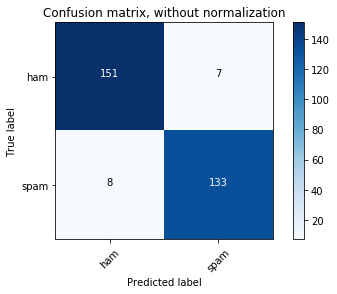

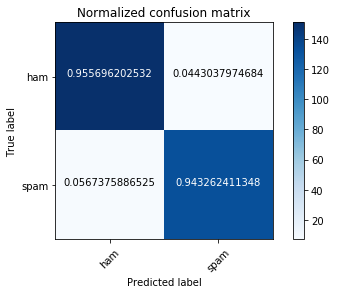

In [81]:
cnf_matrix3 = confusion_matrix(label_test3, label_pred3)
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=naive_model3.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=naive_model3.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# С лемматизацией результаты стали хуже, чем без нее. Количество спама, размеченного как не спам, столько же, сколько для первого токенизатора
# Количество неспама, размеченного как спам, увеличилось.
# Попробую другой токенизатор все же (который на считает пунктуацию)

In [11]:
class LemmaTokenizer_no_p(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t.lower()) for t in tokenize_no_punct(doc)]

In [9]:
bow4 = CountVectorizer(tokenizer=LemmaTokenizer_no_p())
bowed_messages4 = bow4.fit_transform(new_data['message'])
msg_train4, msg_test4, label_train4, label_test4 = train_test_split(bowed_messages4, new_data['label'], test_size=0.2)

naive_model4 = MultinomialNB()
naive_model4.fit(msg_train4, label_train4)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
label_pred4 = naive_model4.predict(msg_test4)
print(classification_report(label_test4, label_pred4))

             precision    recall  f1-score   support

        ham       0.95      0.98      0.97       130
       spam       0.99      0.96      0.97       169

avg / total       0.97      0.97      0.97       299



Confusion matrix, without normalization
[[128   2]
 [  7 162]]
Normalized confusion matrix
[[ 0.98461538  0.01538462]
 [ 0.04142012  0.95857988]]


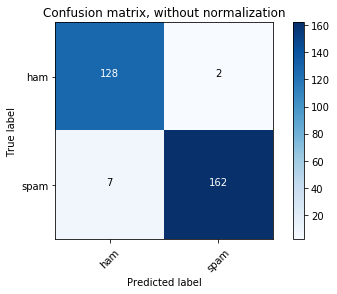

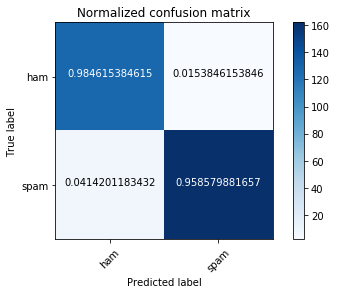

In [13]:
cnf_matrix4 = confusion_matrix(label_test4, label_pred4)
plt.figure()
plot_confusion_matrix(cnf_matrix4, classes=naive_model4.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix4, classes=naive_model4.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [87]:
# Другой лемматизатор (который не размечает пунктуацию как токен)
# Не спама, размеченного как спам, стало меньше. Спама, размеченного как не спам, стало на 1 меньше, по сравнению с предыдущим лемматизатором

In [12]:
def StemTokenizer_no_p(txt):
    return [stem(t.lower()) for t in tokenize_no_punct(txt)]

In [13]:
bow5 = CountVectorizer(tokenizer=StemTokenizer_no_p)
bowed_messages5 = bow5.fit_transform(new_data['message'])
msg_train5, msg_test5, label_train5, label_test5 = train_test_split(bowed_messages5, new_data['label'], test_size=0.2)

naive_model5 = MultinomialNB()
naive_model5.fit(msg_train5, label_train5)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [14]:
label_pred5 = naive_model5.predict(msg_test5)
print(classification_report(label_test5, label_pred5))

             precision    recall  f1-score   support

        ham       0.95      0.98      0.96       153
       spam       0.98      0.95      0.96       146

avg / total       0.96      0.96      0.96       299



Confusion matrix, without normalization
[[150   3]
 [  8 138]]
Normalized confusion matrix
[[ 0.98039216  0.01960784]
 [ 0.05479452  0.94520548]]


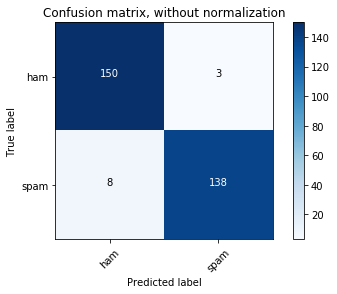

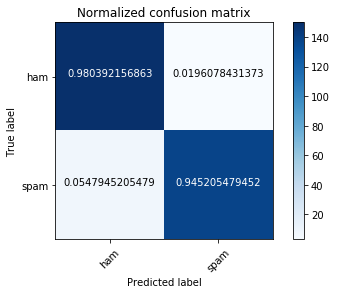

In [15]:
cnf_matrix5 = confusion_matrix(label_test5, label_pred5)
plt.figure()
plot_confusion_matrix(cnf_matrix5, classes=naive_model5.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix5, classes=naive_model5.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [22]:
# Удивительно, но со стэммингом результаты лучше, чем с лемматизацией. 

In [34]:
bow6 = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english')
bowed_messages6 = bow6.fit_transform(new_data['message'])
msg_train6, msg_test6, label_train6, label_test6 = train_test_split(bowed_messages6, new_data['label'], test_size=0.2)

naive_model6 = MultinomialNB()
naive_model6.fit(msg_train6, label_train6)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [35]:
label_pred6 = naive_model6.predict(msg_test6)
print(classification_report(label_test6, label_pred6))

             precision    recall  f1-score   support

        ham       0.93      0.97      0.95       145
       spam       0.97      0.93      0.95       154

avg / total       0.95      0.95      0.95       299



Confusion matrix, without normalization
[[140   5]
 [ 11 143]]
Normalized confusion matrix
[[ 0.96551724  0.03448276]
 [ 0.07142857  0.92857143]]


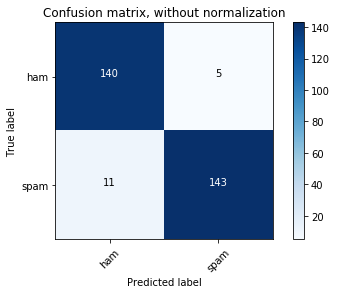

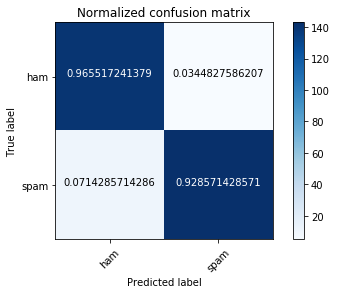

In [36]:
cnf_matrix6 = confusion_matrix(label_test6, label_pred6)
plt.figure()
plot_confusion_matrix(cnf_matrix6, classes=naive_model6.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix6, classes=naive_model6.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# Включение стоп-слов не помогло, спама, размеченного как не спам, довольно много.

In [37]:
bow7 = CountVectorizer(tokenizer=tokenize_no_punct, min_df=0.15, max_df=0.85)
bowed_messages7 = bow7.fit_transform(new_data['message'])
msg_train7, msg_test7, label_train7, label_test7 = train_test_split(bowed_messages7, new_data['label'], test_size=0.2)

naive_model7 = MultinomialNB()
naive_model7.fit(msg_train7, label_train7)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [38]:
label_pred7 = naive_model7.predict(msg_test7)
print(classification_report(label_test7, label_pred7))

             precision    recall  f1-score   support

        ham       0.85      0.77      0.81       141
       spam       0.81      0.88      0.84       158

avg / total       0.83      0.83      0.83       299



Confusion matrix, without normalization
[[109  32]
 [ 19 139]]
Normalized confusion matrix
[[ 0.77304965  0.22695035]
 [ 0.12025316  0.87974684]]


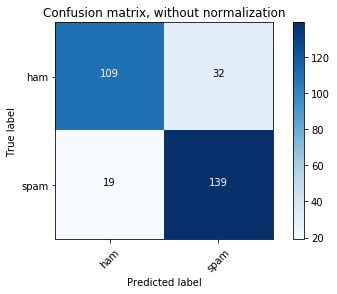

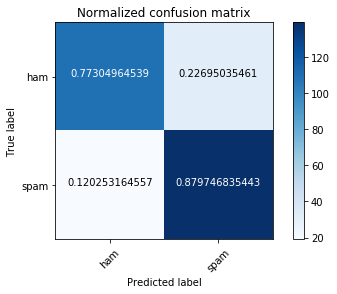

In [39]:
cnf_matrix7 = confusion_matrix(label_test7, label_pred7)
plt.figure()
plot_confusion_matrix(cnf_matrix7, classes=naive_model7.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix7, classes=naive_model7.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# c min_df, max_df намного больше ошибок первого и второго родов

In [52]:
bow8 = TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english')
bowed_messages8 = bow8.fit_transform(new_data['message'])
msg_train8, msg_test8, label_train8, label_test8 = train_test_split(bowed_messages8, new_data['label'], test_size=0.2)

naive_model8 = MultinomialNB()
naive_model8.fit(msg_train8, label_train8)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [53]:
label_pred8 = naive_model8.predict(msg_test8)
print(classification_report(label_test8, label_pred8))

             precision    recall  f1-score   support

        ham       0.95      0.96      0.95       157
       spam       0.95      0.94      0.95       142

avg / total       0.95      0.95      0.95       299



Confusion matrix, without normalization
[[150   7]
 [  8 134]]
Normalized confusion matrix
[[ 0.95541401  0.04458599]
 [ 0.05633803  0.94366197]]


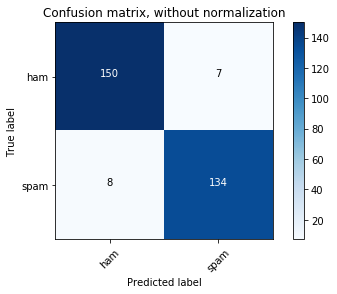

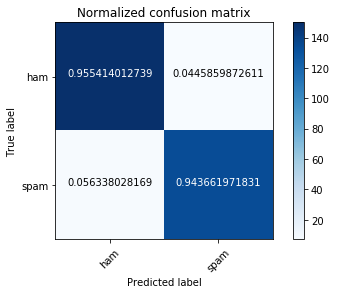

In [54]:
cnf_matrix8 = confusion_matrix(label_test8, label_pred8)
plt.figure()
plot_confusion_matrix(cnf_matrix8, classes=naive_model8.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix8, classes=naive_model8.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [55]:
# из всего испробованного результаты по ошибкам средние.

In [56]:
# в качестве "еще что-нибудь" попробую не приводить к нижнему регистру
bow9 = TfidfVectorizer(tokenizer=tokenize_no_punct, stop_words='english', lowercase=False)
bowed_messages9 = bow9.fit_transform(new_data['message'])
msg_train9, msg_test9, label_train9, label_test9 = train_test_split(bowed_messages9, new_data['label'], test_size=0.2)

naive_model9 = MultinomialNB()
naive_model9.fit(msg_train9, label_train9)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [57]:
label_pred9 = naive_model9.predict(msg_test9)
print(classification_report(label_test9, label_pred9))

             precision    recall  f1-score   support

        ham       0.97      0.97      0.97       150
       spam       0.97      0.97      0.97       149

avg / total       0.97      0.97      0.97       299



Confusion matrix, without normalization
[[145   5]
 [  4 145]]
Normalized confusion matrix
[[ 0.96666667  0.03333333]
 [ 0.02684564  0.97315436]]


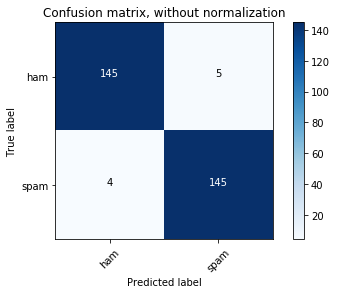

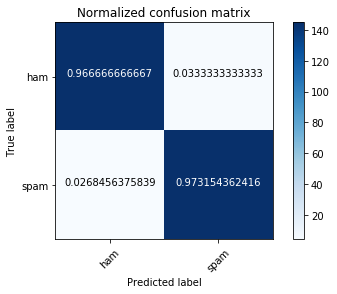

In [58]:
cnf_matrix9 = confusion_matrix(label_test9, label_pred9)
plt.figure()
plot_confusion_matrix(cnf_matrix9, classes=naive_model9.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix9, classes=naive_model9.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [59]:
# удивительно, но результаты лучше, чем у TfidfVectorizer с лемматизатором и с приведением к нижнему регистру

In [41]:
#extra
ham_prob = round(4825/(4825+747), 2)
spam_prob = round(747/(4825+747), 2)
ham = messages.loc[messages['label'] == 'ham']
ham747 = ham.sample(n=747) #рандомно выбрать 747 строчек из не спама
spam = messages.loc[messages['label'] == 'spam']
new_df = ham747.append(spam).sample(frac=1).reset_index(drop=True)
print(new_df.head())

  label                                            message
0   ham                        Well done and ! luv ya all 
1  spam  Sppok up ur mob with a Halloween collection of...
2   ham  SHIT BABE.. THASA BIT MESSED UP.YEH, SHE SHUDV...
3   ham                             Your pussy is perfect!
4   ham  yeah sure thing mate haunt got all my stuff so...


In [61]:
print(naive_model9.classes_)

['ham' 'spam']


In [84]:
bow10 = CountVectorizer(tokenizer=tokenize_no_punct, stop_words='english')
bowed_messages10 = bow10.fit_transform(new_df['message'])
msg_train10, msg_test10, label_train10, label_test10 = train_test_split(bowed_messages10, new_df['label'], test_size=0.2)

naive_model10 = MultinomialNB(class_prior=[ham_prob, spam_prob])
naive_model10.fit(msg_train10, label_train10)
label_pred10 = naive_model10.predict(msg_test10)
print(classification_report(label_test10, label_pred10))

             precision    recall  f1-score   support

        ham       0.94      1.00      0.97       154
       spam       1.00      0.93      0.96       145

avg / total       0.97      0.97      0.97       299



Confusion matrix, without normalization
[[154   0]
 [ 10 135]]
Normalized confusion matrix
[[ 1.          0.        ]
 [ 0.06896552  0.93103448]]


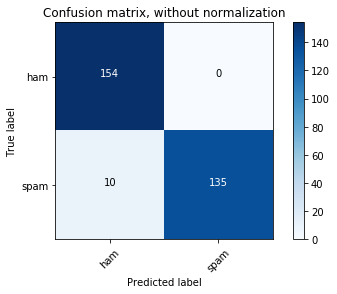

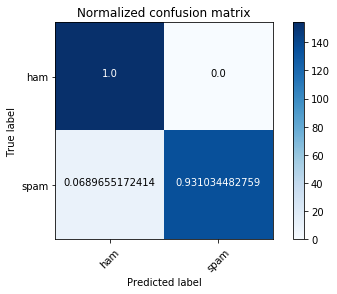

In [85]:
cnf_matrix10 = confusion_matrix(label_test10, label_pred10)
plt.figure()
plot_confusion_matrix(cnf_matrix10, classes=naive_model10.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix10, classes=naive_model10.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# Все ошибки в последнем классификаторе - это нераспознанный спам. Причем я пробовала матрицу тф-идф, с теми же значениями аргументов, там все было очень плохо
# 0.83
# В общем и целом, средние показатели работы модели находятся в промежутке [0.95, 0.98], что неплохо. Для рандомных данных из не спама
# меры тоже находятся в этом промежутке.

In [16]:
# task 2
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

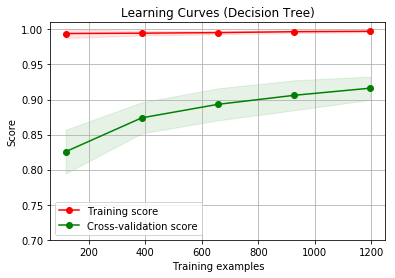

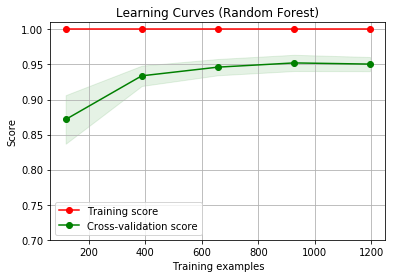

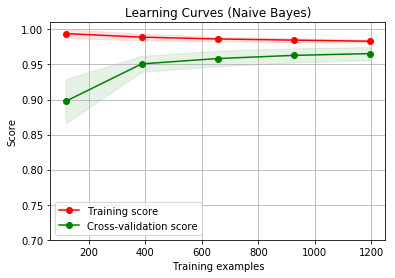

In [23]:
X, y = bowed_messages2, new_data['label']

title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier(min_samples_split=5)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(n_estimators = 100)
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = MultinomialNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [24]:
# худшие результаты у Decision Tree. У RandomForest отличный training score, но cross-validation score лучше у байесовского
# классификатора

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scikitplot/classifiers.py:51: UserWarning: "plot_ks_statistic" method already in clf. Overriding anyway. This may result in unintended behavior.
  'Overriding anyway. This may result in unintended behavior.'.format(key))
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scikitplot/classifiers.py:51: UserWarning: "plot_learning_curve" method already in clf. Overriding anyway. This may result in unintended behavior.
  'Overriding anyway. This may result in unintended behavior.'.format(key))
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scikitplot/classifiers.py:51: UserWarning: "plot_confusion_matrix" method already in clf. Overriding anyway. This may result in unintended behavior.
  'Overriding anyway. This may result in unintended behavior.'.format(key))
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scikitplot/classifi

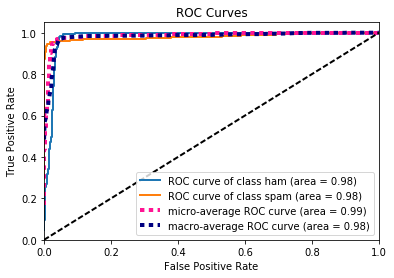

In [32]:
# Compute ROC curve and ROC area for each class
classifier_factory(naive_model2)
naive_model2.plot_roc_curve(bowed_messages2, new_data['label'], random_state=1)
plt.show()

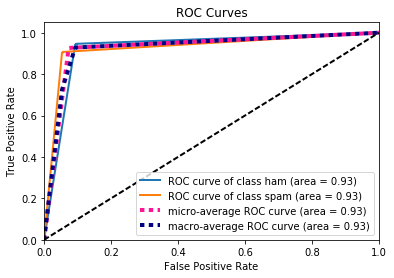

In [33]:
estimator1 = DecisionTreeClassifier(min_samples_split=5)
classifier_factory(estimator1)
estimator1.plot_roc_curve(bowed_messages2, new_data['label'], random_state=1)
plt.show()

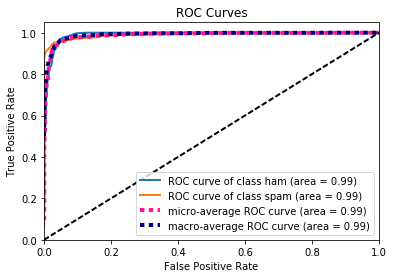

In [34]:
estimator2 = RandomForestClassifier(n_estimators = 100)
classifier_factory(estimator2)
estimator2.plot_roc_curve(bowed_messages2, new_data['label'], random_state=1)
plt.show()

In [35]:
# Во всех случаях не спам классифицируется чуть лучше, чем спам. Хуже всех снова дерево решений

In [36]:
print('Classification report for Naive Bayes')
print(classification_report(label_test2, label_pred2))
estimator1.fit(msg_train2, label_train2)
label_pred_estimator1 = estimator1.predict(msg_test2)
print('Classification report for Decision Tree')
print(classification_report(label_test2, label_pred_estimator1))
estimator2.fit(msg_train2, label_train2)
label_pred_estimator2 = estimator2.predict(msg_test2)
print('Classification report for Random Forest')
print(classification_report(label_test2, label_pred_estimator2))

Classification report for Naive Bayes
             precision    recall  f1-score   support

        ham       0.95      0.98      0.96       142
       spam       0.98      0.95      0.96       157

avg / total       0.96      0.96      0.96       299

Classification report for Decision Tree
             precision    recall  f1-score   support

        ham       0.90      0.94      0.92       142
       spam       0.94      0.90      0.92       157

avg / total       0.92      0.92      0.92       299

Classification report for Random Forest
             precision    recall  f1-score   support

        ham       0.90      1.00      0.95       142
       spam       1.00      0.90      0.95       157

avg / total       0.95      0.95      0.95       299



In [ ]:
# По средним показателям хуже всех показало себя снова дерево решений. В лесе плохо то, что у него многовато спама, размеченного
# как не спам. См. confusion matrix ниже

Confusion matrix, without normalization
[[142   0]
 [ 15 142]]
Normalized confusion matrix
[[ 1.         0.       ]
 [ 0.0955414  0.9044586]]


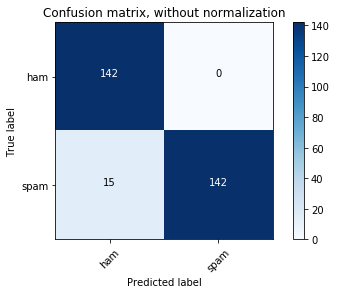

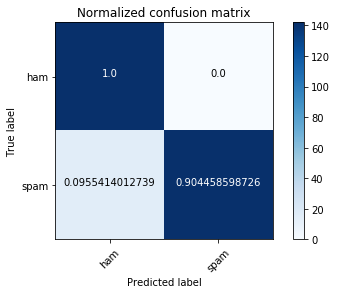

In [38]:
cnf_matrix_random = confusion_matrix(label_test2, label_pred_estimator2)
plt.figure()
plot_confusion_matrix(cnf_matrix_random, classes=naive_model2.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix_random, classes=naive_model2.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [58]:
# task 3
# new_df - рандомно выбранные 747 строчек не спама и столько же спама
new_df["len"] = new_df['message'].str.len()
#new_df["len"].map(new_df['message'].str.len()).astype(int)
new_df['excl'] = new_df['message'].str.count('!')
new_df['comma'] = new_df['message'].str.count(',')
new_df['digits'] = new_df.apply(lambda x: sum(sym.isdigit() for sym in x['message']), axis=1)
new_df['caps'] = new_df.apply(lambda x: sum(sym.isupper() for sym in x['message']), axis=1)

0        1
1       15
2       86
3        1
4        1
5        1
6        4
7        1
8        2
9        4
10      18
11      29
12      17
13       3
14      16
15       9
16       1
17       0
18      24
19       2
20      34
21      15
22       0
23      21
24      23
25      38
26      18
27       2
28      25
29       1
        ..
1464     1
1465    64
1466     6
1467    11
1468    13
1469     1
1470     5
1471    17
1472     3
1473     8
1474    23
1475     8
1476    15
1477     2
1478     1
1479    23
1480     3
1481    13
1482     6
1483     1
1484    14
1485    25
1486    26
1487    20
1488     1
1489    18
1490     1
1491    20
1492    25
1493    18
Name: caps, dtype: int64


In [61]:
new_df.groupby(['label']).agg({'len': 'mean'})

,len
label,
ham,70.262383
spam,138.670683


In [62]:
new_df.groupby(['label']).agg({'excl': 'mean'})

,excl
label,
ham,0.243641
spam,0.729585


In [63]:
new_df.groupby(['label']).agg({'comma': 'mean'})

,comma
label,
ham,0.297189
spam,0.551539


In [64]:
new_df.groupby(['label']).agg({'digits': 'mean'})

,digits
label,
ham,0.313253
spam,15.812584


In [65]:
new_df.groupby(['label']).agg({'caps': 'mean'})

,caps
label,
ham,4.282463
spam,15.469880


In [66]:
# сообщение спама в среднем длиннее, в спаме намного больше цифр и букв в верхнем регистре. мне кажется, другие фичи будут играть
# намного меньше роли, чем перечисленные в этом комментарии. Но все равно попробую всё давать классификатору

In [70]:
features = ['len', 'excl', 'comma', 'digits', 'caps']
X, y = new_df[features], new_df['label']
X.head()

,len,excl,comma,digits,caps
0,27,1,0,0,1
1,116,0,1,4,15
2,116,0,2,2,86
3,22,1,0,0,1
4,142,0,0,0,1


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [74]:
naive = MultinomialNB()
naive.fit(np.array(X_train), np.array(y_train))
new_predict = naive.predict(X_test)
print(classification_report(y_test, new_predict))

             precision    recall  f1-score   support

        ham       0.84      0.97      0.90       134
       spam       0.97      0.85      0.91       165

avg / total       0.91      0.90      0.90       299



Confusion matrix, without normalization
[[130   4]
 [ 25 140]]
Normalized confusion matrix
[[ 0.97014925  0.02985075]
 [ 0.15151515  0.84848485]]


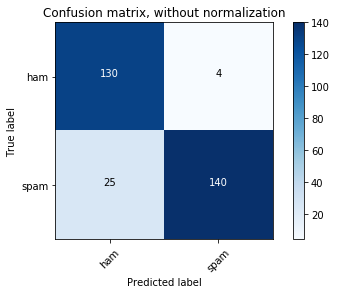

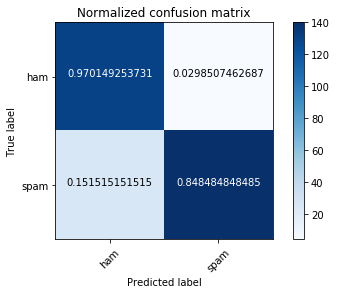

In [75]:
cnf_matrix_own = confusion_matrix(y_test, new_predict)
plt.figure()
plot_confusion_matrix(cnf_matrix_own, classes=naive.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix_own, classes=naive.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [76]:
# c CountVectorizer результаты были лучше. Очень много спама, отнесенного к не спаму

In [77]:
# к вопросу перед первым заданием. Какие результаты покажет dummy classifier, который будет всем новым наблюдениям присваивать класс ham?

Confusion matrix, without normalization
[[153   0]
 [146   0]]
Normalized confusion matrix
[[ 1.  0.]
 [ 1.  0.]]


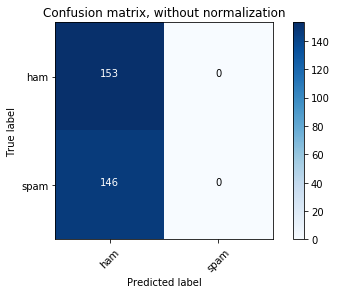

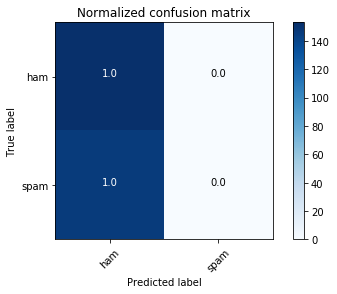

In [83]:
dummy = DummyClassifier(strategy="constant", constant='ham')
dummy.fit(msg_train, label_train)
dummy_label = dummy.predict(msg_test)
cnf_matrix_dummy = confusion_matrix(label_test, dummy_label)
plt.figure()
plot_confusion_matrix(cnf_matrix_dummy, classes=naive.classes_,
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(cnf_matrix_dummy, classes=naive.classes_, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# очень плохо. Нам нужно выделить спам, а он не выделяется